**Import Statements**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

import re
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from warnings import filterwarnings
filterwarnings('ignore')



**Load the dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving UpdatedResumeDataSet.csv to UpdatedResumeDataSet (1).csv


In [ ]:
import pandas as pd
data = pd.read_csv('UpdatedResumeDataSet.csv')

In [ ]:
data = pd.read_csv('./data/UpdatedResumeDataSet.csv')

FileNotFoundError: [Errno 2] No such file or directory: './data/UpdatedResumeDataSet.csv'

In [ ]:
data.head()

,Resume,Category
0,This is a sample resume for a Technical Writer...,Technical Writer
1,This is a sample resume for a Full Stack Devel...,Full Stack Developer
2,This is a sample resume for a Blockchain Devel...,Blockchain Developer
3,This is a sample resume for a Frontend Develop...,Frontend Developer
4,This is a sample resume for a Technical Writer...,Technical Writer


In [ ]:
data['Category'].value_counts()

,count
Category,
AI Engineer,63
Cloud Engineer,62
Database Administrator,62
Frontend Developer,59
Software Engineer,59
Mobile App Developer,57
Business Analyst,55
Technical Writer,49
Machine Learning Engineer,49


In [ ]:
x_axis = data['Category'].value_counts().index.to_list()

y_axis = data['Category'].value_counts().to_list()

**Visualise the data**

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

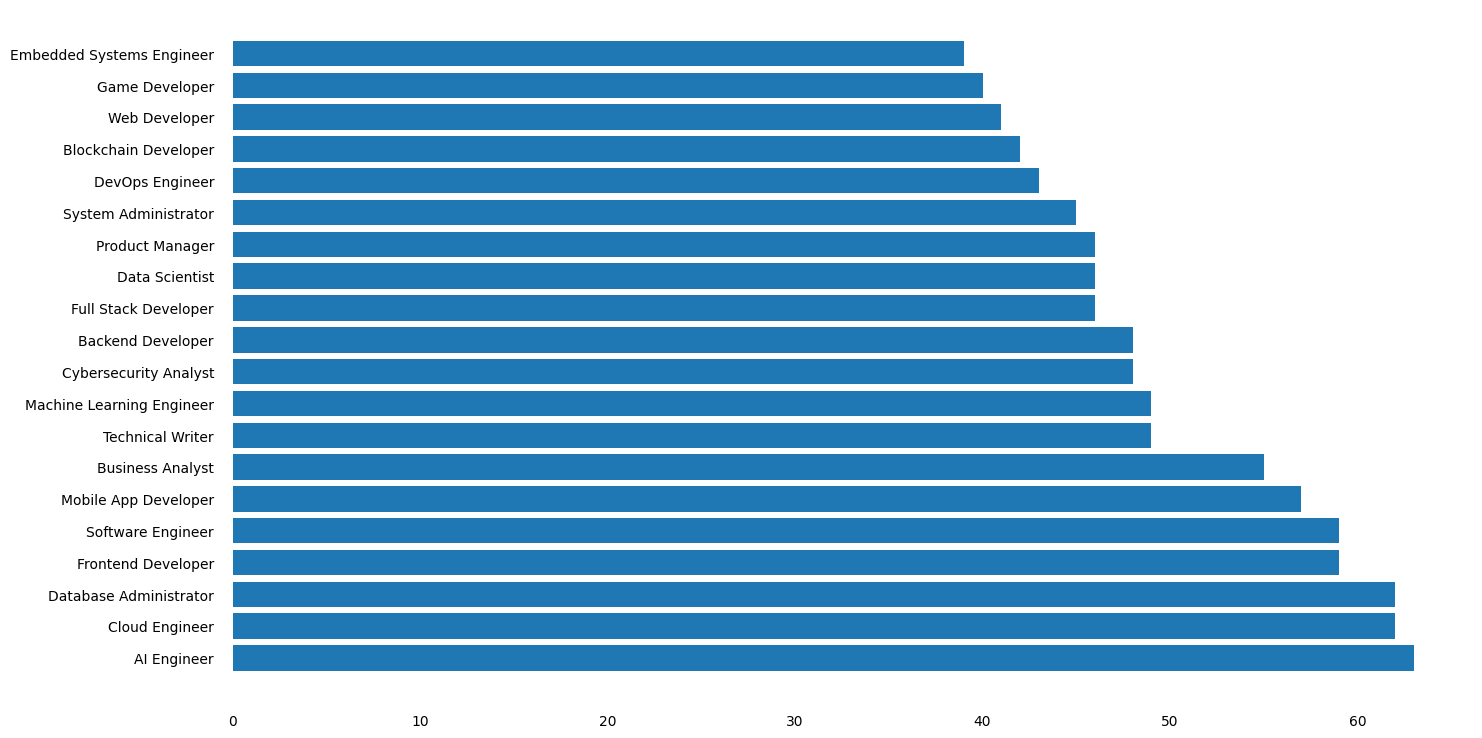

In [ ]:
def barPlot():
  fig, ax = plt.subplots(figsize =(16, 9))

  # Horizontal Bar Plot
  ax.barh(x_axis,y_axis)

  for s in ['top', 'bottom', 'left', 'right']:
      ax.spines[s].set_visible(False)

  # Remove x, y Ticks
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

  # Add padding between axes and labels
  ax.xaxis.set_tick_params(pad = 5)
  ax.yaxis.set_tick_params(pad = 10)

  # Add x, y gridlines
  ax.grid(b = True, color ='grey',
          linestyle ='-.', linewidth = 0.5,
          alpha = 0.2)

  # Show top values
  ax.invert_yaxis()

  # Add annotation to bars
  for i in ax.patches:
      plt.text(i.get_width()+0.2, i.get_y()+0.5,
              str(round((i.get_width()), 2)),
              fontsize = 10, fontweight ='bold',
              color ='grey')

  # Add Plot Title
  ax.set_title('Category',loc ='left', )

  # Add Text watermark
  fig.text(0.9, 0.15, 'Jeeteshgavande30', fontsize = 12,color ='grey', ha ='right', va ='bottom',alpha = 0.7)

  # Show Plot
  plt.show()

barPlot()

**Data Pre-processing**

In [ ]:
def custom_standardization(Text):
    Text = re.sub('<br />', ' ', Text) #removing HTML
    Text = re.sub('https?://\S+|www\.\S+','', Text)#removing hyperlink
    Text = re.sub('RT|cc','', Text)# remove RT and cc
    Text = re.sub('#\S+','', Text) # remove hashtags

    Text = re.sub('\[.*?\]','', Text) #removing square brackets
    Text = re.sub('[^\x00-\x7f]','', Text)

    Text = re.sub( '[%s]' % re.escape(string.punctuation),'', Text) #removing puncuation
    Text = re.sub('\w*\d\w*','', Text)#remove words containing numbers
    return Text


In [ ]:
data['CleanResume'] = data.Resume.apply(lambda x: custom_standardization(x))

In [ ]:
data.head()

,Resume,Category,CleanResume
0,This is a sample resume for a Technical Writer...,Technical Writer,This is a sample resume for a Technical Writer...
1,This is a sample resume for a Full Stack Devel...,Full Stack Developer,This is a sample resume for a Full Stack Devel...
2,This is a sample resume for a Blockchain Devel...,Blockchain Developer,This is a sample resume for a Blockchain Devel...
3,This is a sample resume for a Frontend Develop...,Frontend Developer,This is a sample resume for a Frontend Develop...
4,This is a sample resume for a Technical Writer...,Technical Writer,This is a sample resume for a Technical Writer...


In [ ]:
X = data['CleanResume']
y = data['Category']

In [ ]:
# Replacing space between charecter(e.g "Data Science" to "DataScience")
# To get single array EX=> {Data:6},{Science:7},{HR:8}
# So we will have some array of 2D and some of 1D. That can cause the problem..
for i in range(len(y)):
  y[i] = y[i].replace(" ","")

**Split into test and train**

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(X,y, random_state=42, shuffle=True, test_size=0.17)

**Tokenize features and labels**

In [ ]:
vocab_size = 6000
embedding_dim = 16
max_length = 6000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

**Tokenizing features -**

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok, lower=True)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [ ]:
X_sequences = tokenizer.texts_to_sequences(X_train)
X_padded = pad_sequences(X_sequences,maxlen=max_length,padding=padding_type, truncating=trunc_type)

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)

**Tokenizing labels -**

In [ ]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(y)
word_index = tokenizer.word_index

In [ ]:
y_sequences = tokenizer.texts_to_sequences(y_train)
# y_padded = pad_sequences(y_sequences,maxlen=300,padding=padding_type, truncating=trunc_type)

In [ ]:
y_testing_sequences = tokenizer.texts_to_sequences(y_test)
# y_testing_padded = pad_sequences(y_testing_sequences,maxlen=300, padding=padding_type, truncating=trunc_type)

In [ ]:
y_sequences

[[3],
 [11],
 [12],
 [2],
 [3],
 [6],
 [14],
 [12],
 [6],
 [6],
 [6],
 [10],
 [14],
 [12],
 [9],
 [10],
 [1],
 [14],
 [18],
 [4],
 [3],
 [7],
 [17],
 [2],
 [20],
 [2],
 [11],
 [9],
 [13],
 [19],
 [16],
 [15],
 [1],
 [3],
 [15],
 [15],
 [16],
 [1],
 [11],
 [10],
 [7],
 [2],
 [3],
 [3],
 [6],
 [15],
 [8],
 [10],
 [16],
 [19],
 [4],
 [12],
 [13],
 [10],
 [7],
 [1],
 [17],
 [9],
 [8],
 [14],
 [8],
 [19],
 [18],
 [2],
 [20],
 [11],
 [4],
 [4],
 [6],
 [5],
 [5],
 [2],
 [10],
 [5],
 [12],
 [8],
 [2],
 [3],
 [2],
 [2],
 [17],
 [20],
 [9],
 [8],
 [17],
 [14],
 [17],
 [13],
 [6],
 [13],
 [14],
 [7],
 [6],
 [2],
 [7],
 [18],
 [7],
 [20],
 [2],
 [15],
 [4],
 [1],
 [4],
 [10],
 [10],
 [6],
 [14],
 [9],
 [16],
 [7],
 [17],
 [4],
 [1],
 [19],
 [6],
 [14],
 [20],
 [6],
 [1],
 [12],
 [18],
 [17],
 [1],
 [10],
 [13],
 [1],
 [5],
 [5],
 [15],
 [12],
 [12],
 [1],
 [4],
 [16],
 [16],
 [5],
 [2],
 [12],
 [14],
 [18],
 [16],
 [18],
 [20],
 [18],
 [10],
 [7],
 [7],
 [16],
 [8],
 [3],
 [8],
 [13],
 [1],
 [9],


**Building the model**

In [ ]:
embedding_dim = 64
# input vocab of size 6000, and output embedding dimension of size 64

model = Sequential([
  Embedding(vocab_size, embedding_dim,),
  Bidirectional(LSTM(64)),
  Dense(64, activation='relu'),
  Dense(26, activation='softmax')# 26 lables are there....
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# loss = tf.keras.losses.sparse_categorical_crossentropy(from_logits=False)
# loss = tf.keras.losses.categorical_crossentropy(from_logits=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

y_padded = np.array(y_sequences)
y_testing_padded = np.array(y_testing_sequences)

In [ ]:
earlyStopping = EarlyStopping(monitor='val_accuracy',patience=1)

history = model.fit(X_padded,y_padded,epochs = 10, validation_data=(testing_padded,y_testing_padded ), callbacks=[earlyStopping])

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 384ms/step - accuracy: 0.0681 - loss: 3.2210 - val_accuracy: 0.0588 - val_loss: 3.0004
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 336ms/step - accuracy: 0.0825 - loss: 2.9902 - val_accuracy: 0.1647 - val_loss: 2.6505
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.2150 - loss: 2.4571 - val_accuracy: 0.4294 - val_loss: 1.7547
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 334ms/step - accuracy: 0.5340 - loss: 1.5006 - val_accuracy: 0.7941 - val_loss: 1.0504
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.8787 - loss: 0.8389 - val_accuracy: 1.0000 - val_loss: 0.5756
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.9813 - loss: 0.4817 - val_accuracy: 0.9353 - val_loss: 0.2938


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('/content/drive/MyDrive/resume_classifier_model.h5')

**evaluating**

In [ ]:
score = model.evaluate(testing_padded, y_testing_padded, verbose=1)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9352 - loss: 0.2942


In [ ]:
len(testing_padded)

170

In [ ]:
len(y_testing_padded)

170

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2938406467437744
Test Accuracy: 0.9352940917015076


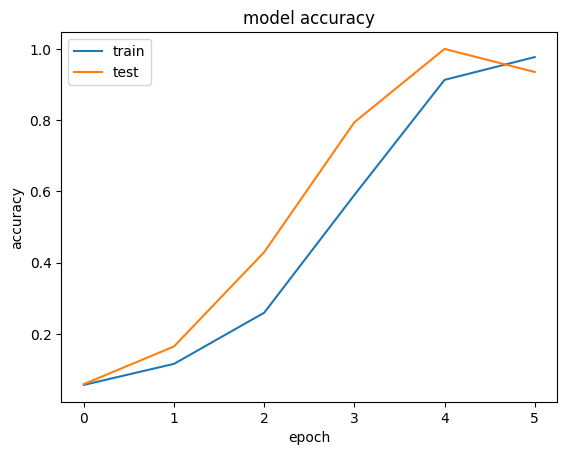

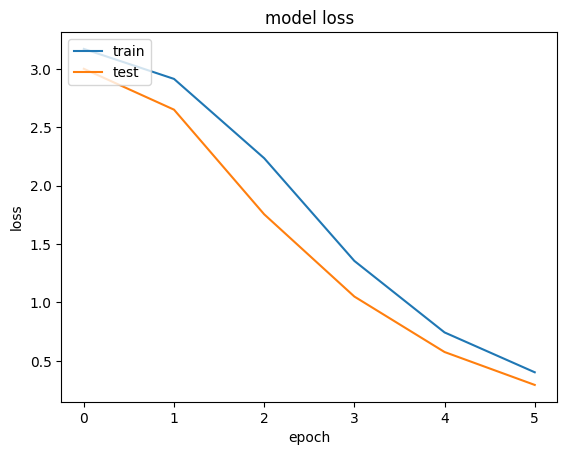

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
input_resume = input("Enter your resume content here: ")

In [ ]:
cleaned_resume = custom_standardization(input_resume) # Apply the same preprocessing as before
input_sequence = tokenizer.texts_to_sequences([cleaned_resume]) # Tokenize
input_padded = pad_sequences(input_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type) # Pad

In [ ]:
prediction = model.predict(input_padded)
predicted_category_index = np.argmax(prediction) # Get the index of the predicted category

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


In [ ]:
# Get a list of all categories
categories = list(tokenizer.word_index.keys())
# Get predicted category using the index
predicted_category = categories[predicted_category_index-1]
# Print the prediction
print("Predicted Category:", predicted_category)

Predicted Category: fullstackdeveloper
